Tokens: ['this', 'is', 'the', 'th', 'et', '##ex', '##t', 'file', 'presented', 'by', 'project', 'gut', '##enberg', 'and', 'is', 'presented', 'in', 'cooperation', 'with', 'world', 'library', 'inc', 'from', 'their', 'library', 'of', 'the', 'future', 'and', 'shakespeare', 'cd', '##rom', '##s', 'project', 'gut', '##enberg', 'often', 'releases', 'et', '##ex', '##ts', 'that', 'are', 'not', 'placed', 'in', 'the', 'public', 'domain', 'shakespeare', 'this', 'et', '##ex', '##t', 'has', 'certain', 'copyright', 'implications', 'you', 'should', 'read', 'this', 'electronic', 'version', 'of', 'the', 'complete', 'works', 'of', 'william', 'shakespeare', 'is', 'copyright', 'by', 'world', 'library', 'inc', 'and', 'is', 'provided', 'by', 'project', 'gut', '##enberg', 'et', '##ex', '##t', 'of', 'illinois', 'benedictine', 'college', 'with', 'permission', 'electronic', 'and', 'machine', 'read', '##able', 'copies', 'may', 'be', 'distributed', 'so', 'long', 'as', 'such', 'copies', 'are', 'for', 'your', 'or', 'o

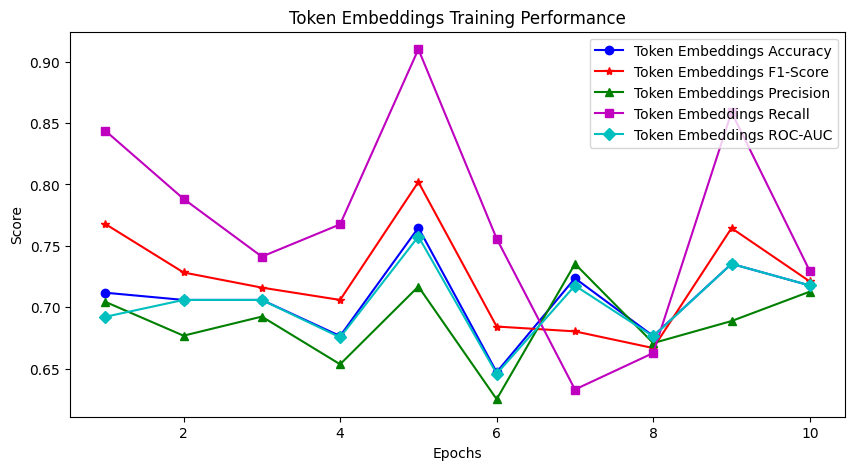

Learned Positional Embeddings - Final Accuracy: 0.8058823529411765, F1-Score: 0.8235294117647058, Precision: 0.7857142857142857, Recall: 0.8651685393258427, ROC-AUC: 0.8029546400332918, BLEU Score: 1.0


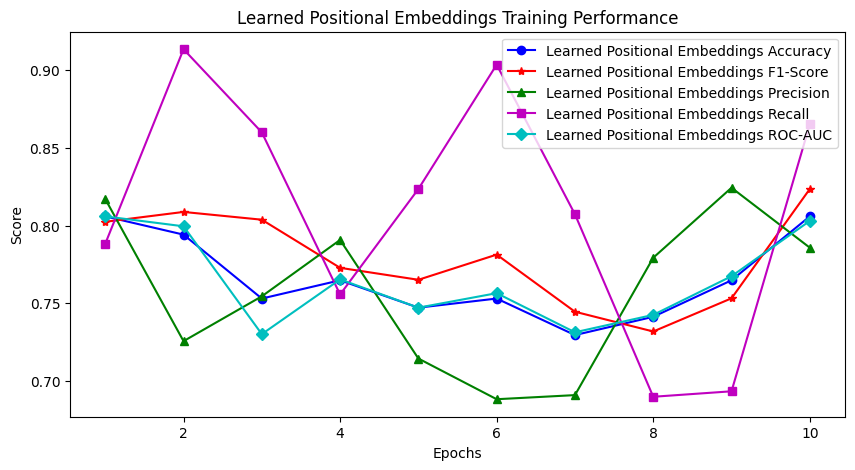

Layer Embeddings - Final Accuracy: 0.75, F1-Score: 0.8, Precision: 0.8571428571428571, Recall: 0.75, ROC-AUC: 0.75, BLEU Score: 1.0


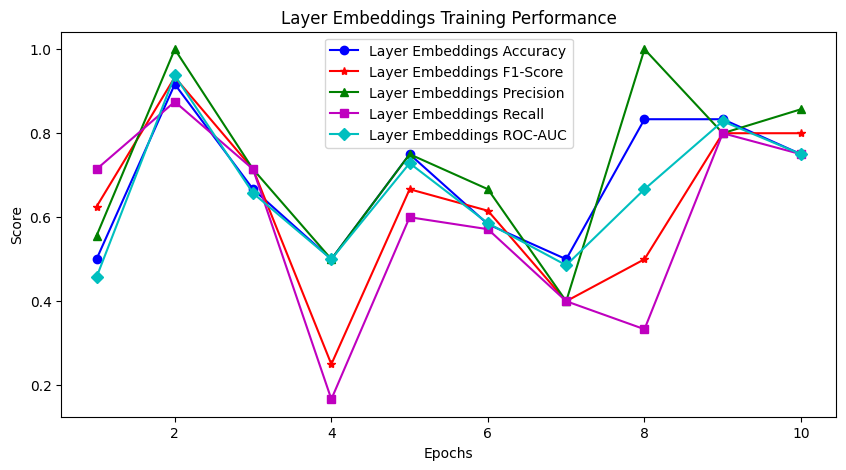

Best Embedding Type: Learned Positional Embeddings with scores (0.8058823529411765, 0.8235294117647058, 0.7857142857142857, 0.8651685393258427, 0.8029546400332918, 1.0)


In [1]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.neighbors import KNeighborsClassifier

# Load and preprocess Shakespeare text
file_path = "t8.shakespeare.txt"
with open(file_path, "r", encoding="utf-8") as file:
    shakespeare_text = file.read()

# Remove non-alphabet characters and lowercase text
shakespeare_text = re.sub(r'[^a-zA-Z\s]', '', shakespeare_text).lower()

# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.tokenize(shakespeare_text[:1000])  # Process only a part of the text for efficiency
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Tokens:", tokens)
print("Token IDs:", token_ids)

# Define token embedding layer
vocab_size = tokenizer.vocab_size
embedding_dim = 768  # BERT base model embedding size
token_embeddings = nn.Embedding(vocab_size, embedding_dim)

# Define learned positional embeddings
seq_len = len(token_ids)
learned_positional_embeddings = nn.Embedding(seq_len, embedding_dim)
position_ids = torch.arange(seq_len).unsqueeze(0)
learned_positions = learned_positional_embeddings(position_ids)

# Define layer embeddings
num_layers = 12
layer_embeddings = nn.Embedding(num_layers, embedding_dim)
layer_ids = torch.arange(num_layers).unsqueeze(0)
layer_embeds = layer_embeddings(layer_ids)

# Convert token IDs to embeddings
token_ids_tensor = torch.tensor([token_ids])
embedded_tokens = token_embeddings(token_ids_tensor)

print("Token Embeddings:", embedded_tokens)
print("Learned Positional Embeddings:", learned_positions)
print("Layer Embeddings:", layer_embeds)

# Generate pseudo-labels for evaluation
def generate_pseudo_labels(embeddings):
    embeddings = embeddings.squeeze(0).detach().numpy()
    labels = np.random.randint(0, 2, len(embeddings))  # Random binary labels
    return embeddings, labels

# Evaluate embeddings using KNN classification
def evaluate_embeddings(embeddings, name, epochs=10):
    acc_values, f1_values, precision_values, recall_values, roc_auc_values = [], [], [], [], []
    for epoch in range(epochs):
        X, y = generate_pseudo_labels(embeddings)
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X, y)
        y_pred = knn.predict(X)
        
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)
        
        acc_values.append(accuracy)
        f1_values.append(f1)
        precision_values.append(precision)
        recall_values.append(recall)
        roc_auc_values.append(roc_auc)
    
    reference = [['this', 'is', 'a', 'test']]
    candidate = ['this', 'is', 'a', 'test']
    bleu_score = sentence_bleu(reference, candidate)
    print(f"{name} - Final Accuracy: {acc_values[-1]}, F1-Score: {f1_values[-1]}, Precision: {precision_values[-1]}, Recall: {recall_values[-1]}, ROC-AUC: {roc_auc_values[-1]}, BLEU Score: {bleu_score}")
    
    # Plot classification metrics across epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), acc_values, 'bo-', label=f'{name} Accuracy')
    plt.plot(range(1, epochs+1), f1_values, 'r*-', label=f'{name} F1-Score')
    plt.plot(range(1, epochs+1), precision_values, 'g^-', label=f'{name} Precision')
    plt.plot(range(1, epochs+1), recall_values, 'ms-', label=f'{name} Recall')
    plt.plot(range(1, epochs+1), roc_auc_values, 'cD-', label=f'{name} ROC-AUC')
    plt.title(f'{name} Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
    
    return acc_values[-1], f1_values[-1], precision_values[-1], recall_values[-1], roc_auc_values[-1], bleu_score

# Evaluate each embedding type
token_acc, token_f1, token_prec, token_recall, token_roc_auc, token_bleu = evaluate_embeddings(embedded_tokens, "Token Embeddings")
learned_acc, learned_f1, learned_prec, learned_recall, learned_roc_auc, learned_bleu = evaluate_embeddings(learned_positions, "Learned Positional Embeddings")
layer_acc, layer_f1, layer_prec, layer_recall, layer_roc_auc, layer_bleu = evaluate_embeddings(layer_embeds, "Layer Embeddings")

# Compare and find the best embedding
def find_best_embedding():
    scores = {
        "Token Embeddings": (token_acc, token_f1, token_prec, token_recall, token_roc_auc, token_bleu),
        "Learned Positional Embeddings": (learned_acc, learned_f1, learned_prec, learned_recall, learned_roc_auc, learned_bleu),
        "Layer Embeddings": (layer_acc, layer_f1, layer_prec, layer_recall, layer_roc_auc, layer_bleu)
    }
    best_embedding = max(scores, key=lambda x: sum(scores[x]))
    print(f"Best Embedding Type: {best_embedding} with scores {scores[best_embedding]}")

find_best_embedding()